In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# NOTEBOOK IMPORTS
import os, glob, warnings, pickle, re, traceback
import numpy as np
from shutil import copyfile
from datetime import datetime
from fuzzywuzzy import process
import easyocr

# IMAGE IMPORTS
from PIL import Image
import cv2

# GIS IMPORTS
from affinetransformation import *
from affine import Affine
import pandas as pd
import geopandas as gpd
import rasterio as rio

# IMAGE IMPORTS
# from skimage.morphology import skeletonize
# from skimage import img_as_bool, img_as_ubyte


# PLOTTING IMPORTS
import matplotlib.pyplot as plt

# CUSTOM UTILITIES
from IndexUtils import * 
from TileUtils import *
from TileNameFinder import *
from ReadDate import *
from featurematching import *

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")
initialize = False

%matplotlib widget

c:\Users\fhacesga\Anaconda3\envs\yolo\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\fhacesga\AppData\Local\Temp\ipykernel_8356\1811205482.py:17: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. H

WARNING  Python>=3.10 is required, but Python==3.8.18 is currently installed 


IO directories depending on which machine. 

In [3]:
username = os.getlogin()

dnn_params = {}
dnn_params['CLNN'] = {}
dnn_params['TPNN'] = {}
dnn_params['RLNN'] = {}
dnn_params['FLNN'] = {}
dnn_params['TLNN'] = {}


if username == 'fhacesga':
    base_input_path   = r"D:\RECTDNN\uncompress_2\\"
    base_output_path  = r"D:\RECTDNN\processing\\"
    ref_dir  = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"
    tiled_yolo_model_paths = [
        r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CORNERS\CornersTiled_111324.pt",
        r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FANN\FANN_large_YOLO.pt"
    ]
elif username == 'fhace':
    base_input_path   = r"C:\Users\fhace\Desktop\FIRMs\data\Uncompress\\"
    ref_dir = r"C:\Users\fhace\Desktop\FIRMs\data\AAA_ReferenceDatasets\\"
    base_output_path = r"C:\Users\fhace\Desktop\FIRMs\data\Outputs\\"
    # dnn_params['TLNN']['model_weights']    = r"C:\Users\fhace\Desktop\FIRMs\data\BBNN\curr_weights.pt"
    dnn_params['CLNN']['model_checkpoint'] = r"C:\Users\fhace\Desktop\FIRMs\data\RLNN\checkpoint_101423.pth"
    dnn_params['TPNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\TPNN\checkpoint_091523_pyramids_2.pth"
    dnn_params['RLNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\RLNN\checkpoint_091323.pth"
    
else:
    base_input_path   = r"D:\Desktop\FIRMsDigitizing\data\HistoricalFIRMS"
    base_output_path  = r"D:\Desktop\FIRMsDigitizing\processing"
    ref_dir  = r"C:\Users\franc\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"

if not initialize:
    initialize = init_databases(ref_dir)

try:
    reader
except:
    reader = easyocr.Reader(['en']) 

In [4]:
proc_dir = r"C:\Users\fhacesga\OneDrive - University Of Houston\000_FIRMsPaper\Validation\input_data\RegTiles\run\\"

For each image we are processing, identify street corners

In [5]:
tiles = glob.glob(proc_dir + "tiles_goodstreets\*.tif")

In [6]:
out = processTiledYOLOs(tiles, tiled_yolo_model_paths, ['CornerCoordinates', 'street_corners'], proc_dir, imsizes=[256, 320])

Making images half size for tiled inference


  0%|          | 0/5 [00:00<?, ?it/s]

Reading from C:\Users\fhacesga\OneDrive - University Of Houston\000_FIRMsPaper\Validation\input_data\RegTiles\run\\CornerCoordinates.pkl
Reading from C:\Users\fhacesga\OneDrive - University Of Houston\000_FIRMsPaper\Validation\input_data\RegTiles\run\\street_corners.pkl


In [7]:
cornercoords_dict = out[0]
streetcorner_dict = out[1]

In [8]:
corners     = gpd.read_file(r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\OSM_Roads\TexasRoads_filtered_strict_3857_nondupe_smaller_harris.gpkg")
roads_gdf   = gpd.read_file(r"C:\Users\fhacesga\Downloads\TexasRoads_filtered_strict_3857.gpkg", engine='pyogrio', use_arrow=True)

In [9]:
corner_dir = os.path.join(get_largest_subdirectory(os.path.join(proc_dir, "street_corners")), "pickles")

if os.path.isdir(os.path.join(proc_dir, "focus")):
    referencing_dir  =  os.path.join(proc_dir, "focus") + "\\"
    print(f"Focus found, using {referencing_dir}")

registration_dir = os.path.join(proc_dir, "registration")
os.makedirs(registration_dir, exist_ok=True)

print(corner_dir)

C:\Users\fhacesga\OneDrive - University Of Houston\000_FIRMsPaper\Validation\input_data\RegTiles\run\\street_corners\exp2\pickles


In [10]:
np.set_printoptions(precision=8) 

In [11]:
def normCoords(A, B):
    offsets = np.min(A, axis=0)
    return A - offsets, B - offsets

def updateResults(list1, list2, verbose=False):
    combined_dict = {}
    all_matches = list1 + list2

    if not all_matches:
        return []

    # Check data format (tuple vs dict)
    is_dict_format = isinstance(all_matches[0], dict)

    for entry in all_matches:
        if is_dict_format:
            key = entry["real_idx"]
            d1, d2 = entry["d1"], entry["d2"]
        else:
            key = entry[0]
            d1, d2 = entry[2], entry[3]

        try:
            current_ratio = d1 / d2
        except ZeroDivisionError:
            continue

        if key not in combined_dict:
            combined_dict[key] = entry
        else:
            prev = combined_dict[key]
            prev_ratio = (prev["d1"] / prev["d2"]) if is_dict_format else (prev[2] / prev[3])
            if current_ratio < prev_ratio:
                combined_dict[key] = entry

    combined_list = list(combined_dict.values())
    if verbose:
        print("Results Update:", len(list1), len(list2), len(combined_list))
    return combined_list
def most_popular_indices_2d_flexible(uv_vectors, eps=0.1, iteration=0, n_iters=10, min_cluster_size=10):
    """
    uv_vectors: np.ndarray of shape (N, 2) representing delta vectors (dx, dy)
    eps: base clustering threshold (in normalized space)
    iteration: current iteration index (0-based)
    n_iters: total iterations expected
    """
    # Compute angle and magnitude
    angles = np.degrees(np.arctan2(uv_vectors[:, 1], uv_vectors[:, 0])) % 360
    magnitudes = np.linalg.norm(uv_vectors, axis=1)

    # Normalize
    angle_norm = angles / 360.0  # 0–1
    length_norm = magnitudes / (np.max(magnitudes) + 1e-6)

    # Decay angle weight as we get closer to convergence
    angle_weight = max(1 - (iteration / n_iters), 0.1)
    length_weight = 1.0

    combined = np.vstack([
        angle_norm * angle_weight,
        length_norm * length_weight
    ]).T

    db = DBSCAN(eps=eps, min_samples=2).fit(combined)
    labels, counts = np.unique(db.labels_[db.labels_ != -1], return_counts=True)

    if len(counts) == 0:
        return []

    # Keep all clusters with sufficient support
    good_clusters = [label for label, count in zip(labels, counts) if count >= min_cluster_size]

    indices = [i for i, label in enumerate(db.labels_) if label in good_clusters]
    return indices, combined

In [ ]:
def plotMatchesNew(fromPoints, toPoints, angles, idx, coordsBPrime=None, add_basemap=True):
    """
    Plots original and matched points, their directional vectors, and angle histogram.
    `idx` should be the final filtered indices to highlight in yellow.
    """

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot all points
    fromPoints.plot(ax=axs[0],  color='red', markersize=5)
    toPoints.plot(ax=axs[0],    color='blue', markersize=5)

    # Full vector field
    axs[0], uv = calcQuiver(axs[0], fromPoints, toPoints, color="black")

    # Add basemap (optional)
    if add_basemap:
        try:
            cx.add_basemap(axs[0])
        except:
            print("Error adding Basemap")

    # Highlight final filtered matches
    axs[0], uv_filtered = calcQuiver(axs[0], fromPoints.iloc[idx], toPoints.iloc[idx], color="yellow")

    axs[0].scatter(coordsBPrime[:, 0], coordsBPrime[:, 1], marker='x', c='red', label='B warped')

    # Angle histograms
    bins = np.linspace(-180, 180, 100)
    axs[1].hist(angles, bins, label="All", alpha=0.5)
    axs[1].hist(angles[idx], bins, label="Filtered", color="orange", alpha=0.7)
    axs[1].set_xlabel("Adjustment Bearing (degrees)")
    axs[1].set_ylabel("Frequency (n)")
    axs[1].legend()

    return fig, axs


def addGCPsandIndices(coordsA, coordsB, idx, gcps, weights):
    if gcps is None:
        newA = coordsA[idx, :]
        newB = coordsB[idx, :]
        weights = weights[idx]
    else:
        newA = np.vstack((coordsA[idx, :], gcps[['image_X', 'image_Y']].to_numpy()))
        newB = np.vstack((coordsB[idx, :], gcps[['X', 'Y']].to_numpy()))
        gcp_weights = np.ones(len(gcps))  # assume equal confidence for GCPs
        weights = np.concatenate((weights[idx], gcp_weights))
        print(newA)
        print(newB)
    return newA, newB, weights

def adjustGCPs(gcps):
    coordsA = gcps[['image_X', 'image_Y']].to_numpy()
    coordsB = gcps[['X', 'Y']].to_numpy()
    initial = similarityTransformation(coordsA[:, 0], coordsA[:, 1], coordsB[:, 0], coordsB[:, 1],verbose=False)
    matrix = initial.matrix
    coordsBprime = np.hstack((coordsB, np.ones((coordsB.shape[0], 1)))) @ np.linalg.inv(matrix).T    
    coordsAprime = np.hstack((coordsA, np.ones((coordsA.shape[0], 1)))) @ matrix.T    

    distances = np.sqrt((coordsBprime[:, 0] - coordsA[:, 0]) ** 2 + (coordsBprime[:, 1] - coordsA[:, 1]) ** 2)
    print(distances)
    return matrix, distances, distances > -10000

def apply_adjustment_to_gdf(gdf, matrix, idx=None):
    """Apply 3×3 affine (homogeneous) matrix M to a subset of a GeoDataFrame and return only adjusted rows with all fields preserved."""
    cord_arry = getCoordsGDF(gdf)
    if idx is None:
        idx = np.arange(cord_arry.shape[0])

    cord_arry = np.hstack((cord_arry[idx], np.ones((len(idx), 1))))
    xy1_t = cord_arry @ matrix.T

    # Extract and transform only selected rows
    gdf_subset = gdf.iloc[idx].copy()
    gdf_subset['geometry'] = gpd.points_from_xy(xy1_t[:, 0], xy1_t[:, 1])

    return gdf_subset

def extract_weights(matchresults, q_weight=0.4, o_weight=0.3, l_weight=0.3):
    """
    Extracts match weights from matchresults list.
    Uses quality tuple (q, o, l) if available, otherwise returns weight=1.
    """
    weights = []
    for m in matchresults:
        if isinstance(m, dict) and "qualities" in m:
            q, o, l = m["qualities"]
            weight = (q_weight * q) + (o_weight * o) + (l_weight * l)
        else:
            weight = 1.0
        weights.append(weight)
    return np.array(weights, dtype=np.float32)


def adjustFromMatchingV4(matchresults, 
                         idx=None, 
                         plot=False, 
                         verbose=False, 
                         dbscan_eps=0.04, 
                         logging_dir=None, 
                         iteration_struct=(0, 10),
                         n_internal_passes=10,
                         filter_topn=None, 
                         distance_thresh=None,
                         gcps=None):
    
    # Optional confidence filtering
    if filter_topn is not None:
        print(f"Filtering top {filter_topn}")
        conf = [a[8][0] / a[8][1] for a in matchresults]
        indices = np.argsort(conf)[:filter_topn]
        matchresults = [matchresults[i] for i in indices]

    if idx is None:
        idx = np.arange(len(matchresults), dtype=np.int32)

    if isinstance(matchresults[0], dict):
        image_coords = [x["image_coords"] for x in matchresults]
        real_coords  = [x["real_coords"]  for x in matchresults]
    else:
        image_coords = [x[5] for x in matchresults]
        real_coords  = [x[4] for x in matchresults]

    weights=extract_weights(matchresults)

    fromPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy(
        [pt[0] for pt in image_coords], [pt[1] for pt in image_coords]))
    toPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy(
        [pt[0] for pt in real_coords], [pt[1] for pt in real_coords]))

    coordsA = getCoordsGDF(fromPoints)
    coordsB = getCoordsGDF(toPoints)

    # Iterative refinement loop
    i, checker = 0, True
    prev_len = len(idx)

    while checker and i < n_internal_passes:
        # Re-inject GCPs each round and do index slicing
        coordsA_aug, coordsB_aug, weights = addGCPsandIndices(coordsA, coordsB, idx, gcps, weights)

        # Estimate similarity transform FROM image TO real
        transform = similarityTransformation(
            coordsA_aug[:, 0], coordsA_aug[:, 1],
            coordsB_aug[:, 0], coordsB_aug[:, 1],
            verbose=False, rotation_limit=3, weights=weights             
        )

        matrix = transform.matrix

        # Transform image to real
        reprojectedpoints   = getCoordsGDF(apply_adjustment_to_gdf(fromPoints, matrix, idx=idx))
        distances           = np.linalg.norm(reprojectedpoints[:, :2] - coordsB[idx], axis=1)

        # reprojectedpoints_oldfashioned = np.hstack((coordsA[idx], np.ones((len(idx), 1)))) @ matrix.T
        # distances_oldfashioned = np.linalg.norm(reprojectedpoints_oldfashioned[:, :2] - coordsB[idx], axis=1)

        # Compute angular and magnitude features (FROM IMAGE TO REAL)
        uv = coordsA - coordsB
        angles = np.degrees(np.arctan2(uv[:, 1], uv[:, 0]))
        magnitudes = np.sqrt(uv[:, 0] ** 2 + uv[:, 1] ** 2)
        test = np.vstack((normArry(angles), normArry(magnitudes))).T
        test[np.isnan(test)] = 0

        # DBSCAN-based filtering
        db_idx, current_values = most_popular_indices_2d_flexible(
            test, eps=dbscan_eps, iteration=iteration_struct[0], n_iters=iteration_struct[1])

        # Distance-based filtering
        dist_thresh = 3 * np.median(distances)
        dist_idx = np.where(distances <= dist_thresh)[0]

        # print("IDX",np.where(idx)[0].shape[0])
        # print("DISTNACE", np.where(dist_idx)[0].shape[0])
        # print("DBSCAN", np.where(db_idx)[0].shape[0])

        # Combine filters
        idx = np.intersect1d(np.intersect1d(idx, dist_idx), db_idx)
        # print("INTERSECT", np.where(idx)[0].shape[0])

        # Relax filter if too few remain
        if len(idx) < 10:
            print("Loosening DBSCAN... ", end="")
            for j in range(1, 11):
                temp_idx, current_values = most_popular_indices_2d_flexible(
                    test, eps=dbscan_eps + 0.02 * j,
                    iteration=iteration_struct[0], n_iters=iteration_struct[1])
                if len(temp_idx) >= 10:
                    idx = np.intersect1d(idx, temp_idx)
                    print(f"Loosened to eps={dbscan_eps + 0.02 * j}")
                    break

        # Stop if convergence
        if len(idx) >= prev_len:
            checker = False
        else:
            prev_len = len(idx)

        # Optional debug plot
        if verbose:
            print(f"Iteration {i}, matrix:\n{np.linalg.inv(matrix).T}")
            fig, axs = plt.subplots(1, 2, figsize=(10, 4))
            axs[0].scatter(coordsA[idx, 0], coordsA[idx, 1], c='black', label='A')
            axs[0].scatter(coordsB[idx, 0], coordsB[idx, 1], c='blue', label='B')
            axs[0].scatter(reprojectedpoints[:, 0], reprojectedpoints[:, 1], marker='x', c='red', label='B warped')
            axs[0].legend()
            axs[1].hist(distances, bins=50)
            axs[1].set_title(f"Residuals (iter {i})")
            fig.savefig(logging_dir[:-3] + f"_iteration{i}.jpg")
            if not plot:
                plt.close(fig)
            else:
                plt.show()

        i += 1

    # Final distance threshold (optional)
    if distance_thresh is not None:
        n_before_dfilt = distances.shape[0]
        distances = distances[idx]
        idx = idx[distances < distance_thresh]
        distances = distances[distances < distance_thresh]

        if verbose:
            print(f"DISTANCE THRESHOLD REMOVED {n_before_dfilt - distances.shape[0]}")
    
    # Optional initial plot
    if logging_dir is not None:
        fig, axs = plotMatchesNew(fromPoints, toPoints, angles, idx, coordsBPrime=reprojectedpoints)
        fig.savefig(logging_dir)
        if not plot:
            plt.close(fig)
        else:
            plt.show()

    return matrix, distances, idx, current_values

def registerImagesV3(group_name, im_corner_gdf, corners_curr, im_corner_arry, descriptor_kwds, 
                     r_initial=500, 
                     r_min=300,
                     verbose=1, 
                     distance_threshold=10,
                     n_iters=20,
                     r_change=0.6,
                     ratio_threshold=0.9,
                     dbscan_ini=0.04,
                     dbscan_max=0.1,
                     gcps=None,
                     logging_dir=None,
                     n_internal_passes=10,
                     remove_stdev=True
                     ):
    
    compoundedAdjustment = np.eye(3)
    
    os.makedirs(logging_dir, exist_ok=True)
    logging_basename = os.path.join(logging_dir, group_name)

    matching_results = None
    im_corner_gdf_adj = im_corner_gdf.copy()
    im_corner_gdf_adj['orig_x'] = im_corner_gdf_adj.geometry.x
    im_corner_gdf_adj['orig_y'] = im_corner_gdf_adj.geometry.y

    registration_struct = {}
    registration_struct['best_grade']       = 1e9
    registration_struct['grades']           = []
    registration_struct['transforms']       = []
    registration_struct['points']           = []

    for i in range(n_iters):
        
        r_current = r_initial * r_change ** i
        dbscan_curr = dbscan_ini + dbscan_ini * i
        
        dbscan_curr = min(dbscan_curr, dbscan_max)
        r_current   = max(r_current, r_min)

        # MAIN P1
        matching_results_curr, _, _ = matching_distances_loosen_distance(im_corner_gdf_adj, corners_curr, 
                                                                    ratio_threshold=ratio_threshold, 
                                                                    match_radius=r_current, 
                                                                    num_retries=10,
                                                                    loosening_factor=0.25,
                                                                    quality_weight=0.5, 
                                                                    **descriptor_kwds)
        
        if matching_results is None:
            matching_results = matching_results_curr
        else:
            matching_results = updateResults(matching_results, matching_results_curr, verbose=verbose>3)
        
        if len(matching_results) < 3:
            raise(Exception(f"Cannot match: {len(matching_results)} matches found for {os.path.basename(ra.files[0])}"))
        
        if i == 0 and gcps is not None:
            current_adjustment, distances, idx = adjustGCPs(gcps)
        else:
            # TODO: REMOVE DB_scan_values. They were for troubleshotting the unending filtering caused by repeated passes during fine tuning
            current_adjustment, distances, idx, DB_scan_values = adjustFromMatchingV4(matching_results, plot=verbose>8, 
                                                        dbscan_eps=dbscan_curr,
                                                        verbose=verbose>8,
                                                        gcps=gcps,
                                                        n_internal_passes=n_internal_passes,
                                                        distance_thresh=r_current,
                                                        iteration_struct = (i, n_iters),
                                                        logging_dir=None if logging_dir is None else logging_basename + f"_iteration{str(i).zfill(2)}.jpg")
        
            matching_results = [matching_results[i] for i in idx]


        im_corner_gdf_adj = apply_adjustment_to_gdf(im_corner_gdf_adj, current_adjustment)

        scale       = np.sqrt(0.5 * (current_adjustment[0,0] ** 2 + current_adjustment[1,1] ** 2))
        translation = np.sqrt(current_adjustment[0,2] ** 2 + current_adjustment[1,2] ** 2)

        if verbose > 0:
            print(np.nanpercentile(distances, [0, 25, 50, 75, 100]), len(matching_results), len(distances[distances<100]))

        if verbose > 3:
            print(f"Distances under 100: {distances[distances<100]}" )
            
        if verbose > 8:
            print(f"Scale {scale:.3e}")
            print(f"Translation {translation:.3e}")
        
        if verbose > 10: 
            print(current_adjustment)
            print("Inverse")
            print(np.linalg.inv(current_adjustment))

        # IF BEST, SAVE AS BEST
        if np.nanpercentile(distances, 50) < registration_struct['best_grade']:
            registration_struct['best_grade']             = np.nanpercentile(distances, 50)
            registration_struct['best_im_corner_gdf_adj'] = im_corner_gdf_adj

        # SAVE CURRENT TIMESTEP VALUES
        registration_struct[i] = {}
        registration_struct[i]['grade']     = np.nanpercentile(distances, 50)
        registration_struct[i]['adjust']    = current_adjustment
        registration_struct[i]['comp_adj']  = compoundedAdjustment
        registration_struct[i]["matching_results"]   = matching_results
        registration_struct[i]["distances"]          = distances
        registration_struct[i]["DB_scan_values"]     = DB_scan_values
        
        registration_struct['points'].append(im_corner_gdf_adj)
        registration_struct['grades'].append(np.nanpercentile(distances, 50))
        registration_struct['transforms'].append(current_adjustment)

        # CHECK IF WE HAVE ANY CONDITIONS FOR EARLY STOPPING
        matched_check = np.nanpercentile(distances, 50) < distance_threshold
        conv_check  = np.abs(1 - scale) < 0.002 and translation < distance_threshold

        if (matched_check or conv_check) and i > 1:
            print(matched_check, conv_check)
            break

    with open(logging_basename+".pkl", 'wb') as handle:
        pickle.dump(registration_struct, handle, protocol=pickle.HIGHEST_PROTOCOL)       

    return registration_struct['best_im_corner_gdf_adj'], registration_struct


In [ ]:

def loadGCPs(mydir, tile_dir, ra_ref):
    if os.path.exists(mydir):
        gcps_df = pd.read_csv(mydir)
        gdfs = []

        for i, tile in enumerate(tile_dir):
            curr_name = os.path.basename(tile).split(".")[0]
            curr_df   = gcps_df[gcps_df['ID'] == curr_name]
            curr_gdf = pointsToGeodataFrame(ra_ref[i], curr_df['row'].to_numpy(), curr_df['col'].to_numpy())
            gdfs.append(curr_gdf)
        
        
        a = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

        gcps_df['image_X'] = np.array([aa.x for aa in a['geometry']])
        gcps_df['image_Y'] = np.array([aa.y for aa in a['geometry']])
        return gcps_df
    else:
         return None
def getBBOX(im_file, RLNN):
    bounds, RLNN = findBounds(im_file, RLNN)

    # IF BOUNDS FOUND, USE. ELSE, USE IMAGE BOUNDS
    if len(bounds[0]) < 1:
        print(f"COULD NOT FIND BOUNDS, USING IMAGE EXTENTS {tile_name}")
        bbox = [0, 0, image.shape[0], image.shape[1]]
        datebox = [ int(image.shape[1] * 0.75), int(image.shape[0] * 0.75), image.shape[1], image.shape[0]]
    else:
        bbox = bounds[0].boxes.xyxy.numpy().astype(np.int32)[0].flatten()
    return bbox, RLNN

def getTileCorners(tile_dir, ra_ref, conf_thresh=0.3, filter_by_bounding_box=True):

    tile_name = os.path.basename(tile_dir).split(".")[0]

    with open(f"{corner_dir}/{tile_name}.pickle", 'rb') as f:
        x = pickle.load(f)    
        corner_bbox = [a.bbox.to_xyxy() for a in x if a.score.value > conf_thresh]
        corner_arry = np.array([calcCenter(a) for a in corner_bbox ]) * 2
        corner_confs = np.array([a.score.value for a in x if a.score.value > conf_thresh])
        print(f"{len(corner_bbox)} / {len(x)}")

    corner_arry  = np.int32(corner_arry)
    corner_confs = np.float32(corner_confs)

    if filter_by_bounding_box:
        bbox, _ = getBBOX(tile_dir, None)
        corner_arry, corner_confs = cleanCenterBBOX(corner_arry, bbox, opt_return=[corner_confs])

    # USE RASTER TRANSFORM TO GET REAL-WORLD ESTIMATES OF STREET CORNERS
    im_corner_gdf = pointsToGeodataFrame(ra_ref, corner_arry[:, 1], corner_arry[:, 0])
    return im_corner_gdf, corner_confs


def cornerConfsToDescriptorWeights(corner_confs):
    q99 = np.percentile(corner_confs, 99)
    return np.clip(corner_confs / q99, 0, 1)

def estimate_per_image_transforms(im_corner_gdf_adj):
    """Estimate similarity transforms per image from adjusted GDF."""
    transform_dict = {}

    grouped = im_corner_gdf_adj.groupby("source_image")

    for source_image, gdf in grouped:
        if len(gdf) < 3:
            print(f"Skipping {source_image}: not enough points.")
            continue
        
        coords_adj = getCoordsGDF(gdf)

        transform = similarityTransformation(
            gdf["orig_x"].values, gdf["orig_y"].values,
            coords_adj[:, 0], coords_adj[:, 1], rotation_limit=5,
            verbose=False
        )

        transform_dict[source_image] = transform

    return transform_dict

In [14]:
""" THIS IS THE CODE ORIGINALLY USED FOR THE GROUP 
flip=np.array([
    [1, 0, 0],
    [0, -1, 0],
    [0, 0, 1]
    ]) 

conf_thresh = 0.05

for curr_dir in register_tile_names:
    
    ra_ref = []
    im_corner_list = []
    tile_dirs = []
    corner_conf_list = []

    if os.path.isdir(curr_dir):
        print("FOUND GROUPING - USING")
        curr_tile_names = glob.glob(curr_dir + "/*.tif")
        for tile_dir in curr_tile_names:
            curr_ra_ref = rio.open(tile_dir)
            curr_im_corner_gdf, corner_confs = getTileCorners(tile_dir, curr_ra_ref, conf_thresh=conf_thresh)
            curr_im_corner_gdf['source_image'] = tile_dir               # ENCODING NAME
            corner_confs = cornerConfsToDescriptorWeights(corner_confs)
            tile_dirs.append(tile_dir)
            ra_ref.append(curr_ra_ref)
            im_corner_list.append(curr_im_corner_gdf)
            corner_conf_list.append(corner_confs) 
    else:
        curr_ra_ref = rio.open(curr_dir)
        curr_im_corner_gdf, corner_confs = getTileCorners(curr_dir, curr_ra_ref, conf_thresh=conf_thresh)
        curr_im_corner_gdf['source_image'] = curr_dir                   # ENCODING NAME
        corner_confs = cornerConfsToDescriptorWeights(corner_confs)
        ra_ref.append(curr_ra_ref)
        im_corner_list.append(curr_im_corner_gdf)
        tile_dirs.append(curr_dir)
        corner_conf_list.append(corner_confs)

    gcps = loadGCPs(os.path.join(curr_dir, "gcps.csv"), tile_dirs, ra_ref)
    
    # CONVERT LIST TO GEODATAFRAME
    im_corner_gdf      = gpd.GeoDataFrame(pd.concat(im_corner_list))
    im_corner_arry     = np.stack(im_corner_gdf.geometry.apply(lambda point: np.array([point.x, point.y])))
    im_corner_confs    = np.concatenate(corner_conf_list)

    descriptor_kwds = {
         'angle_step'       :   15, 
         'azimuth_radius'   :   [100, 250, 500, 1000, 1500, 2500], # [50, 100, 250, 500, 1000, 1500, 2000, 2500], 
         'overlap'          :   True, 
         'confidences'      :   im_corner_confs
         }
    
    # BOUNDS
    bounds_poly     = enlarged_bounds(ra_ref, n=1.2)
    corners_curr    = gpd.clip(corners, bounds_poly)
    im_corner_gdf_adj, registration_struct = registerImagesV3(os.path.basename(curr_dir).split(".")[0],  
                        im_corner_gdf, corners_curr, im_corner_arry, descriptor_kwds,
                        distance_threshold=5,
                        n_iters=50,
                        r_min=300,
                        r_initial=5000, 
                        ratio_threshold=0.95,
                        r_change=0.95,# 0.95, # 0.8,# 0.995,
                        dbscan_ini=0.04,
                        dbscan_max=0.1,
                        gcps=gcps,
                        verbose=5, logging_dir=f"{registration_dir}/logs/")


    image_transform_dict = estimate_per_image_transforms(im_corner_gdf_adj)

    for i, tile_dir in enumerate(tile_dirs):
        image = cv2.imread(tile_dir)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        tile_name = os.path.basename(tile_dir).split(".")[0]
        print(f"{registration_dir}/{tile_name}.tif")

        transform = image_transform_dict.get(tile_dir)
        if transform is None:
            print(f"No transform found for {tile_name}, skipping.")

        final_transform = transform.matrix @ getMatrixFromAffine(ra_ref[i].transform)
        try:
            with rio.open(f"{registration_dir}/{tile_name}.tif", 'w',
                        driver='GTiff', count=1, dtype=np.uint8,
                        height=image.shape[0], width=image.shape[1],
                        crs='EPSG:3857',
                        transform=rio.Affine(*final_transform.flatten()[:6])) as dst:
                dst.write(image, 1)
        except Exception as e:
            print(e)
            traceback.print_exc()

    error"""

' THIS IS THE CODE ORIGINALLY USED FOR THE GROUP \nflip=np.array([\n    [1, 0, 0],\n    [0, -1, 0],\n    [0, 0, 1]\n    ]) \n\nconf_thresh = 0.05\n\nfor curr_dir in register_tile_names:\n    \n    ra_ref = []\n    im_corner_list = []\n    tile_dirs = []\n    corner_conf_list = []\n\n    if os.path.isdir(curr_dir):\n        print("FOUND GROUPING - USING")\n        curr_tile_names = glob.glob(curr_dir + "/*.tif")\n        for tile_dir in curr_tile_names:\n            curr_ra_ref = rio.open(tile_dir)\n            curr_im_corner_gdf, corner_confs = getTileCorners(tile_dir, curr_ra_ref, conf_thresh=conf_thresh)\n            curr_im_corner_gdf[\'source_image\'] = tile_dir               # ENCODING NAME\n            corner_confs = cornerConfsToDescriptorWeights(corner_confs)\n            tile_dirs.append(tile_dir)\n            ra_ref.append(curr_ra_ref)\n            im_corner_list.append(curr_im_corner_gdf)\n            corner_conf_list.append(corner_confs) \n    else:\n        curr_ra_ref = r

1007 / 3435


Calculating Descriptors:   0%|          | 0/5161 [00:00<?, ?it/s]

Calculating Descriptors:   0%|          | 0/999 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

IDX 313
DISTNACE 288
DBSCAN 289
INTERSECT 269
[  5.67098097  69.87844662 141.75868247 201.71589611 477.92195667] 270 96
Distances under 100: [54.51594971 92.56875793 95.68041691 28.68504566 69.9142089  68.11170482 78.17266194 63.43614772 84.99030766 85.76838488 33.21317724 51.69653855 94.46138742 64.59644007 25.25108392 47.59413111 43.92663097 62.22398288 23.24280698 37.85980089 88.29425518 56.92070384 12.6180031  19.38127027 44.2124645  22.05546791
 86.2409628  53.44649972 12.0775761  57.96619245 24.05110695  5.67098097 62.47733866 48.61995453 61.37834947 23.23869645 45.84334192 89.05635706 98.58644818 52.43751832 44.25068411 47.9477272  59.93931898 63.28311147 54.86406957 77.22689984 32.9051507  34.79536141 34.80092572 10.30444828 24.5345404  44.05949877
 78.20699126 77.97466291 68.87178398 97.66827561 83.76038458 53.91957409 96.11491252 94.36726312 90.24756718 66.86008854 78.94855062 58.22923382 62.73878588 69.86652586 98.22231028 29.24605704 80.01688223 50.80799378 25.62785406 59.0

Calculating Descriptors:   0%|          | 0/999 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Results Update: 270 304 331
IDX 330
DISTNACE 321
DBSCAN 329
INTERSECT 320
[  9.98870699  87.65671435 162.09622831 242.20080835 465.82511619] 310 92
Distances under 100: [17.66127558 74.11765972 78.13834291 35.60120072 61.37392028 46.33941618 60.53899407 29.38523058 83.78833093 37.36290554 98.48666223 33.26745081 35.09908591 66.42051804 92.84081197 96.4942763  70.9365191  84.58875973 62.28367202 57.80386917 71.33082543 37.74952634 68.09744567 50.59243234 62.50078333 78.20567075
 33.92433295 59.36632391  9.98870699 61.90096561 58.80373039 87.61178712 92.4567156  96.43593864 87.79149604 93.40804419 55.57881175 60.9606765  84.4488217  59.74622934 45.45858448 63.86359315 74.69265444 87.08744398 44.17292527 99.9859472  71.91686031 74.55714342 55.79905506 84.26779746 20.47143629 79.12744737
 38.21847316 64.7027425  83.51287543 76.86485012 62.23903917 81.61222901 52.23078672 96.99092461 93.63492568 83.22571961 89.41036598 62.55776153 62.18904671 82.44637264 17.75946644 68.66593641 44.71297573 

Calculating Descriptors:   0%|          | 0/999 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Results Update: 310 321 377
IDX 376
DISTNACE 376
DBSCAN 376
INTERSECT 376
[ 27.59205655 141.04110952 208.19071169 308.01818194 449.32487267] 371 42
Distances under 100: [39.50018754 28.91196678 43.99977264 58.75593568 60.81355693 77.12468478 85.595578   27.59205655 37.84380348 38.77035329 82.97927698 53.89562888 32.93623283 38.15080021 85.21980871 81.82343751 33.35668217 61.03588234 91.87674293 36.26581421 94.75653141 61.18126832 35.39176991 88.81591584 93.94964409 59.52857277
 28.4814041  38.72680801 88.7165628  89.67446318 66.79669554 79.33186961 46.6196812  34.20097503 92.65837093 33.27995859 77.18173363 92.87860467 69.7262651  83.63520446 77.49168292 79.41316578]


Calculating Descriptors:   0%|          | 0/999 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Results Update: 371 335 410
IDX 409
DISTNACE 409
DBSCAN 409
INTERSECT 409
[  3.21282909 168.17046002 242.67835338 335.56070951 428.6262605 ] 401 40
Distances under 100: [89.12566027 78.08836905 92.5520236  79.4006144  36.23604616 85.77909969 63.89810174 82.45681883 90.39131355 83.43331122 62.57364701 70.89096894 38.94350819 86.34300968 71.14415147  3.21282909 70.58171165 45.37519861 31.95884366 42.06368711 65.49290633 73.81752803 85.84991333 43.38283656 44.65838993 41.03398951
 96.2428241  27.54575423 92.3483664  43.38803551 85.84538201 83.76907611 37.74235106 53.51412377 87.11761842 49.27358017 45.63357401 95.66679205 96.37464682 48.59778354]


Calculating Descriptors:   0%|          | 0/999 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Results Update: 401 343 435
IDX 434
DISTNACE 434
DBSCAN 434
INTERSECT 434
[ 13.02592178 163.39638844 251.53483861 329.38066231 406.91827719] 406 38
Distances under 100: [13.02592178 55.75439577 81.87909744 87.58104854 87.14357359 49.37420611 82.40864824 63.32336546 67.08324055 79.49741987 81.39452407 61.3816961  86.45496022 80.61575946 31.32279102 37.46800517 29.65777698 46.76423572 44.89878751 98.81922153 46.96078996 49.73582199 44.33551237 87.78277769 20.38940873 64.63958925
 68.51982856 85.77294269 57.19162312 62.82331302 79.33264941 19.61663373 57.76030766 70.50161897 70.13319901 93.83996484 68.52254314 93.52552328]


Calculating Descriptors:   0%|          | 0/999 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Results Update: 406 342 443
IDX 442
DISTNACE 442
DBSCAN 442
INTERSECT 442
[ 10.37273817 167.39681871 252.2872088  306.81794533 381.81503616] 400 42
Distances under 100: [27.10064279 29.45414828 29.03123032 91.73789858 65.65808276 79.28481534 91.65583188 54.52818916 45.78740641 30.39184337 78.1532594  97.89206807 79.8903847  29.43878448 31.22926615 51.56355138 54.04648554 26.86951289 87.22533538 71.38346706 67.06357624 11.56977709 58.22317803 96.79451542 65.64595037 83.80713202
 85.15414009 88.72890582 75.2319831  83.25649787 37.57519498 10.37273817 80.47326857 79.90659507 16.11356713 38.61601808 28.58005471 83.02581922 54.79970924 89.99688722 44.85525439 64.44022079]


Calculating Descriptors:   0%|          | 0/999 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Results Update: 400 353 446
IDX 445
DISTNACE 444
DBSCAN 445
INTERSECT 444
[  3.56709209 148.87429532 213.19753354 282.82424381 367.50595378] 404 55
Distances under 100: [61.71180442 73.24271171 76.67050109 43.77846144 19.82195447 43.8415395  38.83429929 91.52642529 80.39408199 23.67146739 59.60500882 57.40541824 47.32642607  3.56709209 19.75918844 80.94714395 50.5580237  37.90159767 37.91655715 81.75887365 25.1617322  96.71661261 98.02283704 86.76686989 38.87730323 52.780552
 14.1893559  39.8635287  82.91610529 76.83748082 98.76484288 47.68639442 98.74375032 53.16856632 77.97781322 61.95614165 89.78529423 95.93882211 28.31565809 87.76833573 81.40920655 69.03465494 63.70019637 57.85723188 85.41024883 59.28229421 94.06970014 80.72882038 72.02122284 23.25844177 99.4500316   8.09453279
 92.77501825 83.11452408 98.91141779]


Calculating Descriptors:   0%|          | 0/999 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Results Update: 404 349 427
IDX 426
DISTNACE 426
DBSCAN 426
INTERSECT 426
[  8.14251442 112.01944668 175.62782412 244.30477969 348.97521062] 383 81
Distances under 100: [55.6373468  88.59293657 46.4534199  67.60347328 43.0357875  75.33792229 29.43632191 53.9588955   8.14251442 84.83531844 65.92973221 32.22799196 92.18645934 69.35914086 32.46110899 14.94150374 48.67238028 84.71290101 69.62887694 77.73959506 75.58500188 64.60109644 85.20928733 78.47525744 62.09607188 54.16419816
 63.02378324 40.40479294 41.11668867 52.12935326 93.69982332 90.02371739 43.57874008 59.59717466 93.63225294 69.68928347 16.90552235 78.43021007 87.1879522  73.34568957 88.44178938 51.55274183 51.57759588 93.4281078  54.54782809 80.4161784  37.68571839 95.99849844 93.56802374 62.10677575 72.97619407 79.5097164
 71.03324998 31.24013057 23.06568298 99.23630035 93.94842227 22.61320414 92.52978808 81.22841296 92.64538477 59.03571529 59.67430333 43.19449564 41.61967237 64.4573788  64.20182347 76.49538115 53.93418971 9

Calculating Descriptors:   0%|          | 0/999 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Results Update: 383 364 434
IDX 433
DISTNACE 433
DBSCAN 433
INTERSECT 433
[  9.76925095  98.54554687 162.62045549 216.26927346 330.11878454] 398 102
Distances under 100: [32.73745898 64.20014149 66.67540765 76.43503262 79.05471652 98.52790623 52.02057173 23.09316659 50.43944656 79.58688031 30.28468499 95.22800187 89.20843837 94.55147551 36.09947402 90.70315402 31.0144861  33.18216603 50.96893976 39.21978399 76.47690437 60.6098351  91.55189646 89.72367704 54.13743592 58.81255158
 54.17131541 65.70169853 51.72718896 28.91675932 79.83087698 63.03550164 68.23460638 62.84576231 85.39618331 58.99785763 16.72739513 37.82823729 70.50289127 39.12773039 95.58489757 33.8996567  88.48785209 70.26872723 89.57961    53.5154559  75.99831111 27.88186718 98.12448748 41.70556491 93.07988056  9.76925095
 13.75236408 48.80097168 74.06339376 86.82184851 75.72332282 75.94601138 91.10632183 90.69305835 88.26081069 25.15777898 83.18924474 10.63198409 22.88207274 96.66466685 86.99516573 98.5984688  24.06803048

Calculating Descriptors:   0%|          | 0/999 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Results Update: 398 377 454
IDX 453
DISTNACE 448
DBSCAN 453
INTERSECT 448
[  4.64644527 100.82453556 157.89638335 217.40817181 314.54671766] 396 95
Distances under 100: [84.00577638 41.89819827 17.70096331 34.79725453 66.89406004 79.48652    40.17165322 82.25279769 54.3400064  32.15132833 93.27367528 67.81461983 95.4755013  12.55330449 69.46603438 73.27128138 81.28472991 25.21575443 99.73282241 57.88318768  4.64644527 62.51129134 46.66346955 68.98806722 41.25048085 67.52435581
 47.41893734 73.21807097 68.88172723 43.67134558 73.9498248  39.83682716 39.03063035 95.99394576 77.07602597 82.82880587 81.66637168 61.41345458 67.10049403 61.63282699 79.33589678 82.04416077 64.97100583 86.59455694 70.56216776 73.58680345 72.5096     47.29996691 97.02319918 83.72780909 59.62096796 96.08870282
 84.62203767 88.52982633 78.61183745 42.6466072  85.22756926 94.82703093 73.90329879 83.09008204 47.8899219  48.97244691 76.79258066 64.22405781 73.71008443 16.3780161  39.02854163 79.88316017 92.47870091 

04/21/2025 11:00:11 - INFO - rasterio._env -   GDAL signalled an error: err_no=1, msg='Deleting C:/Users/fhacesga/OneDrive - University Of Houston/000_FIRMsPaper/Validation/input_data/RegTiles/run/registration/4802960055B.tif failed:\nPermission denied'


Deleting C:/Users/fhacesga/OneDrive - University Of Houston/000_FIRMsPaper/Validation/input_data/RegTiles/run/registration/4802960055B.tif failed: Permission denied


Traceback (most recent call last):
  File "C:\Users\fhacesga\AppData\Local\Temp\ipykernel_8356\4245298819.py", line 85, in <module>
    with rio.open(f"{registration_dir}/{tile_name}.tif", 'w',
  File "c:\Users\fhacesga\Anaconda3\envs\yolo\lib\site-packages\rasterio\env.py", line 451, in wrapper
    return f(*args, **kwds)
  File "c:\Users\fhacesga\Anaconda3\envs\yolo\lib\site-packages\rasterio\__init__.py", line 314, in open
    dataset = writer(
  File "rasterio\_io.pyx", line 1430, in rasterio._io.DatasetWriterBase.__init__
  File "rasterio\_io.pyx", line 293, in rasterio._io._delete_dataset_if_exists
  File "rasterio\_err.pyx", line 195, in rasterio._err.exc_wrap_int
rasterio._err.CPLE_AppDefinedError: Deleting C:/Users/fhacesga/OneDrive - University Of Houston/000_FIRMsPaper/Validation/input_data/RegTiles/run/registration/4802960055B.tif failed: Permission denied


  0%|          | 0/100 [00:00<?, ?it/s]

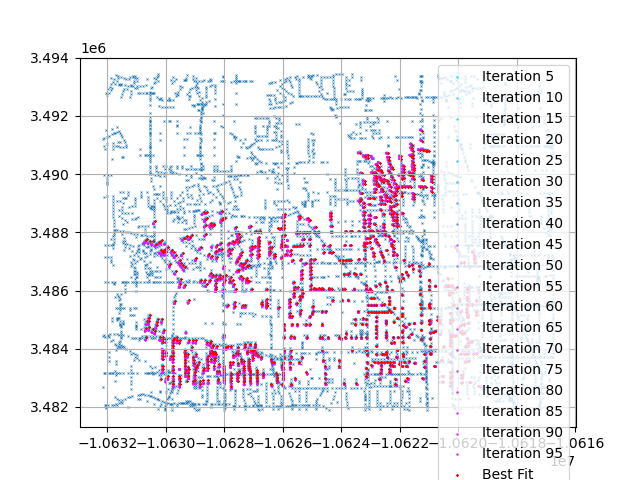

NameError: name 'error' is not defined

In [ ]:
"""
# register_tile_names = glob.glob(proc_dir + "tiles_goodstreets\\*")
# register_tile_names = glob.glob(proc_dir + "tiles_goodstreets_group\\*")
register_tile_names = glob.glob(proc_dir + "registration_group\\*.tif")
# register_tile_names = glob.glob(proc_dir + "tiles_grouped\\*")
# register_tile_names = tiles

conf_thresh = 0.05

for curr_dir in register_tile_names:
    
    ra_ref = []
    im_corner_list = []
    tile_dirs = []
    corner_conf_list = []

    if os.path.isdir(curr_dir):
        print("FOUND GROUPING - USING")
        curr_tile_names = glob.glob(curr_dir + "/*.tif")
        for tile_dir in curr_tile_names:
            curr_ra_ref = rio.open(tile_dir)
            curr_im_corner_gdf, corner_confs = getTileCorners(tile_dir, curr_ra_ref, conf_thresh=conf_thresh)
            curr_im_corner_gdf['source_image'] = tile_dir               # ENCODING NAME
            corner_confs = cornerConfsToDescriptorWeights(corner_confs)
            tile_dirs.append(tile_dir)
            ra_ref.append(curr_ra_ref)
            im_corner_list.append(curr_im_corner_gdf)
            corner_conf_list.append(corner_confs) 
    else:
        curr_ra_ref = rio.open(curr_dir)
        curr_im_corner_gdf, corner_confs = getTileCorners(curr_dir, curr_ra_ref, conf_thresh=conf_thresh)
        curr_im_corner_gdf['source_image'] = curr_dir                   # ENCODING NAME
        corner_confs = cornerConfsToDescriptorWeights(corner_confs)
        ra_ref.append(curr_ra_ref)
        im_corner_list.append(curr_im_corner_gdf)
        tile_dirs.append(curr_dir)
        corner_conf_list.append(corner_confs)

    gcps = loadGCPs(os.path.join(curr_dir, "gcps.csv"), tile_dirs, ra_ref)
    
    # CONVERT LIST TO GEODATAFRAME
    im_corner_gdf      = gpd.GeoDataFrame(pd.concat(im_corner_list))
    im_corner_arry     = np.stack(im_corner_gdf.geometry.apply(lambda point: np.array([point.x, point.y])))
    im_corner_confs    = np.concatenate(corner_conf_list)

    descriptor_kwds = {
         'angle_step'       :   15, 
         'azimuth_radius'   :   [100, 250, 500, 1000, 1500, 2500], # [50, 100, 250, 500, 1000, 1500, 2000, 2500], 
         'overlap'          :   True, 
         'confidences'      :   im_corner_confs
         }
    

    # BOUNDS
    bounds_poly     = enlarged_bounds(ra_ref, n=1.2)
    corners_curr    = gpd.clip(corners, bounds_poly)
    im_corner_gdf_adj, registration_struct = registerImagesV3(os.path.basename(curr_dir).split(".")[0],  
                        im_corner_gdf, corners_curr, im_corner_arry, descriptor_kwds,
                        distance_threshold=5,
                        n_iters=10,
                        n_internal_passes=1,
                        r_min=200,
                        r_initial=500, 
                        ratio_threshold=0.90,
                        r_change=0.95,# 0.95, # 0.8,# 0.995,
                        dbscan_ini=0.04,
                        dbscan_max=1,
                        gcps=gcps,
                        verbose=5, logging_dir=f"{registration_dir}/logs_adjustments/")


    image_transform_dict = estimate_per_image_transforms(im_corner_gdf_adj)

    for i, tile_dir in enumerate(tile_dirs):
        image = cv2.imread(tile_dir)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        tile_name = os.path.basename(tile_dir).split(".")[0]
        print(f"{registration_dir}/{tile_name}.tif")

        transform = image_transform_dict.get(tile_dir)
        if transform is None:
            print(f"No transform found for {tile_name}, skipping.")

        transform = transform.matrix @ getMatrixFromAffine(ra_ref[i].transform)
        
        try:
            with rio.open(f"{registration_dir}/{tile_name}.tif", 'w',
                        driver='GTiff', count=1, dtype=np.uint8,
                        height=image.shape[0], width=image.shape[1],
                        crs='EPSG:3857',
                        transform=rio.Affine(*transform.flatten()[:6])) as dst:
                dst.write(image, 1)
        except Exception as e:
            print(e)
            traceback.print_exc()

        if len(tile_dirs) > 1:
            ind_dir = os.path.join(registration_dir, "IndividualAdjustments")
            os.makedirs(ind_dir, exist_ok=True)


            
            pass

        "" HONESTLY IDEK ABOUT THIS - IF WE COULD FILTER MATCHES MAYBE
        icp_adjust, transform_dict = performWeightedICPonTile([registration_struct['best_im_corner_gdf_adj']], [corners_curr], proc_limit=5000, 
            icp_iterations=100, plot_datasets=[corners_curr], weights=[1, 1/10], 
            plot=False, shear=True, dist_threshold=100)

        icp_transform = icp_adjust @ transform.matrix @ getMatrixFromAffine(ra_ref[i].transform)

        try:
            with rio.open(f"{registration_dir}/{tile_name}_ICP.tif", 'w',
                        driver='GTiff', count=1, dtype=np.uint8,
                        height=image.shape[0], width=image.shape[1],
                        crs='EPSG:3857',
                        transform=rio.Affine(*icp_transform.flatten()[:6])) as dst:
                dst.write(image, 1)
        except Exception as e:
            print(e)
            traceback.print_exc()

        ""       

        """

'C:\\Users\\fhacesga\\OneDrive - University Of Houston\\000_FIRMsPaper\\Validation\\input_data\\RegTiles\\run\\\\tiles_goodstreets_group\\*.tif'

In [40]:
register_tile_names

['C:\\Users\\fhacesga\\OneDrive - University Of Houston\\000_FIRMsPaper\\Validation\\input_data\\RegTiles\\run\\\\tiles_goodstreets_group\\480296']

In [ ]:
detector_conf_thresh = 0.05

registration_kwds = {
    "distance_threshold": 5,
    "n_iters": 50,
    "r_min": 300,
    "r_initial": 5000,
    "ratio_threshold": 0.95,
    "r_change": 0.95, 
    "dbscan_ini": 0.04,
    "dbscan_max": 0.1,
    "gcps": gcps,
    "verbose": 5,
    "logging_dir": f"{registration_dir}/logs/"
}


adjustment_kwds = {
    "distance_threshold"    : 5,
    "n_iters"               : 10,
    "n_internal_passes"     : 1,
    "r_min"                 : 200,
    "r_initial"             : 500,
    "ratio_threshold"       : 0.90,
    "r_change"              : 0.95,
    "dbscan_ini"            : 0.04,
    "dbscan_max"            : 1,
    "gcps"                  : gcps,
    "verbose"               : 5,
    "logging_dir"           : f"{registration_dir}/logs_adjustments/"
}

register_tile_names = glob.glob(proc_dir + "tiles_goodstreets_group/*")

for curr_dir in register_tile_names:
    
    ra_ref = []
    im_corner_list = []
    tile_dirs = []
    corner_conf_list = []

    if os.path.isdir(curr_dir):
        print("FOUND GROUPING - USING")
        curr_tile_names = glob.glob(curr_dir + "/*")
        print(curr_tile_names)
        for tile_dir in curr_tile_names:
            curr_ra_ref = rio.open(tile_dir)
            curr_im_corner_gdf, corner_confs = getTileCorners(tile_dir, curr_ra_ref, conf_thresh=detector_conf_thresh)
            curr_im_corner_gdf['source_image'] = tile_dir               # ENCODING NAME
            corner_confs = cornerConfsToDescriptorWeights(corner_confs)
            tile_dirs.append(tile_dir)
            ra_ref.append(curr_ra_ref)
            im_corner_list.append(curr_im_corner_gdf)
            corner_conf_list.append(corner_confs) 
    else:
        curr_ra_ref = rio.open(curr_dir)
        curr_im_corner_gdf, corner_confs = getTileCorners(curr_dir, curr_ra_ref, conf_thresh=detector_conf_thresh)
        curr_im_corner_gdf['source_image'] = curr_dir                   # ENCODING NAME
        corner_confs = cornerConfsToDescriptorWeights(corner_confs)
        ra_ref.append(curr_ra_ref)
        im_corner_list.append(curr_im_corner_gdf)
        tile_dirs.append(curr_dir)
        corner_conf_list.append(corner_confs)

    gcps = loadGCPs(os.path.join(curr_dir, "gcps.csv"), tile_dirs, ra_ref)
    
    # CONVERT LIST TO GEODATAFRAME
    im_corner_gdf      = gpd.GeoDataFrame(pd.concat(im_corner_list))
    im_corner_arry     = np.stack(im_corner_gdf.geometry.apply(lambda point: np.array([point.x, point.y])))
    im_corner_confs    = np.concatenate(corner_conf_list)

    descriptor_kwds = {
        'angle_step'       :   15, 
        'azimuth_radius'   :   [100, 250, 500, 1000, 1500, 2500], # [50, 100, 250, 500, 1000, 1500, 2000, 2500], 
        'overlap'          :   True, 
        'confidences'      :   im_corner_confs
    }
    
    # BOUNDS
    bounds_poly     = enlarged_bounds(ra_ref, n=1.2)
    corners_curr    = gpd.clip(corners, bounds_poly)

    # REGISTER FIRST PASS
    im_corner_gdf_adj, group_registration_struct = registerImagesV3(os.path.basename(curr_dir).split(".")[0],  
                        im_corner_gdf, corners_curr, im_corner_arry, descriptor_kwds, **registration_kwds)

    # ESTIMATE ORIGINAL TRANSFORMS FROM OUTPUT POINT ADJUSTMENTS
    group_transform_dict = estimate_per_image_transforms(im_corner_gdf_adj)

    # FOR EACH IMAGE
    for i, tile_dir in enumerate(tile_dirs):

        # I/O
        image = cv2.imread(tile_dir)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        tile_name = os.path.basename(tile_dir).split(".")[0]
        print(f"{registration_dir}/{tile_name}.tif")

        # GET TRANSFORM
        transform = group_transform_dict.get(tile_dir)
        if transform is None:
            print(f"No transform found for {tile_name}, skipping.")
        
        # FINALIZE TRANSFORM AND EXPORT RASTER
        transform = transform.matrix @ getMatrixFromAffine(ra_ref[i].transform)
        try:
            with rio.open(f"{registration_dir}/{tile_name}.tif", 'w',
                        driver='GTiff', count=1, dtype=np.uint8,
                        height=image.shape[0], width=image.shape[1],
                        crs='EPSG:3857',
                        transform=rio.Affine(*transform.flatten()[:6])) as dst:
                dst.write(image, 1)
        except Exception as e:
            print(e)
            traceback.print_exc()

        # DO WE NEED TO ADJUST THIS? 
        if len(tile_dirs) > 1:
            ind_dir = os.path.join(registration_dir, "IndividualAdjustments")
            os.makedirs(ind_dir, exist_ok=True)
            """
            # INPUTS AS BEFORE
            bounds_poly_ind     = enlarged_bounds(ra_ref[i], n=1.2)
            corners_curr_ind    = gpd.clip(corners, bounds_poly_ind)
            im_corner_gdf_ind   = gpd.GeoDataFrame(im_corner_list[i])
            
            im_corner_confs_ind = corner_conf_list[i]

            descriptor_kwds = {
                'angle_step'       :   15, 
                'azimuth_radius'   :   [100, 250, 500, 1000, 1500, 2500], # [50, 100, 250, 500, 1000, 1500, 2000, 2500], 
                'overlap'          :   True, 
                'confidences'      :   corner_conf_list[i]
            }
            """
            # GET CURRENT DETECTIONS AND ADJUST
            im_corner_gdf_ind = im_corner_gdf_adj[im_corner_gdf_adj["source_image"] == tile_dir]
            im_corner_arry_ind  = np.stack(im_corner_gdf_ind.geometry.apply(lambda point: np.array([point.x, point.y])))

            # REGISTER FIRST PASS
            im_corner_gdf_adj_ind, registration_struct_ind = registerImagesV3(os.path.basename(curr_dir).split(".")[0],  
                        im_corner_gdf_ind, corners_curr, im_corner_arry_ind, descriptor_kwds, **adjustment_kwds)
            
            image_transform_dict = estimate_per_image_transforms(im_corner_gdf_adj_ind)

            transform = image_transform_dict.get(tile_dir)
            if transform is None:
                print(f"No transform found for {tile_name}, skipping.")
            
            # FINALIZE TRANSFORM AND EXPORT RASTER
            transform = transform.matrix @ getMatrixFromAffine(ra_ref[i].transform)
            try:
                with rio.open(f"{registration_dir}/{tile_name}.tif", 'w',
                            driver='GTiff', count=1, dtype=np.uint8,
                            height=image.shape[0], width=image.shape[1],
                            crs='EPSG:3857',
                            transform=rio.Affine(*transform.flatten()[:6])) as dst:
                    dst.write(image, 1)
            except Exception as e:
                print(e)
                traceback.print_exc()
            
            pass

        """ HONESTLY IDEK ABOUT THIS - IF WE COULD FILTER MATCHES MAYBE
        icp_adjust, transform_dict = performWeightedICPonTile([registration_struct['best_im_corner_gdf_adj']], [corners_curr], proc_limit=5000, 
            icp_iterations=100, plot_datasets=[corners_curr], weights=[1, 1/10], 
            plot=False, shear=True, dist_threshold=100)

        icp_transform = icp_adjust @ transform.matrix @ getMatrixFromAffine(ra_ref[i].transform)

        try:
            with rio.open(f"{registration_dir}/{tile_name}_ICP.tif", 'w',
                        driver='GTiff', count=1, dtype=np.uint8,
                        height=image.shape[0], width=image.shape[1],
                        crs='EPSG:3857',
                        transform=rio.Affine(*icp_transform.flatten()[:6])) as dst:
                dst.write(image, 1)
        except Exception as e:
            print(e)
            traceback.print_exc()

        """        

        
    

FOUND GROUPING - USING
['C:\\Users\\fhacesga\\OneDrive - University Of Houston\\000_FIRMsPaper\\Validation\\input_data\\RegTiles\\run\\\\tiles_goodstreets_group\\480296\\4802960055B.tif', 'C:\\Users\\fhacesga\\OneDrive - University Of Houston\\000_FIRMsPaper\\Validation\\input_data\\RegTiles\\run\\\\tiles_goodstreets_group\\480296\\4802960060B.tif', 'C:\\Users\\fhacesga\\OneDrive - University Of Houston\\000_FIRMsPaper\\Validation\\input_data\\RegTiles\\run\\\\tiles_goodstreets_group\\480296\\4802960080B.tif', 'C:\\Users\\fhacesga\\OneDrive - University Of Houston\\000_FIRMsPaper\\Validation\\input_data\\RegTiles\\run\\\\tiles_goodstreets_group\\480296\\4802960085B.tif', 'C:\\Users\\fhacesga\\OneDrive - University Of Houston\\000_FIRMsPaper\\Validation\\input_data\\RegTiles\\run\\\\tiles_goodstreets_group\\480296\\4802960090B.tif']
1007 / 3435
641 / 1946
1487 / 4335
1877 / 5207
2919 / 7273


Calculating Descriptors:   0%|          | 0/27693 [00:00<?, ?it/s]

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

IDX 4121
DISTNACE 4121
DBSCAN 4120
INTERSECT 4120
IDX 4120
DISTNACE 4120
DBSCAN 4120
INTERSECT 4119
IDX 4119
DISTNACE 4119
DBSCAN 4120
INTERSECT 4118
IDX 4118
DISTNACE 4118
DBSCAN 4120
INTERSECT 4117
IDX 4117
DISTNACE 4117
DBSCAN 4120
INTERSECT 4116
IDX 4116
DISTNACE 4116
DBSCAN 4120
INTERSECT 4115
IDX 4115
DISTNACE 4115
DBSCAN 4120
INTERSECT 4114
IDX 4114
DISTNACE 4114
DBSCAN 4120
INTERSECT 4113
IDX 4113
DISTNACE 4113
DBSCAN 4120
INTERSECT 4112
IDX 4112
DISTNACE 4112
DBSCAN 4120
INTERSECT 4111
[  20.15183554  902.19428304 2513.70036608 3888.59258915 4999.63515639] 4012 7
Distances under 100: [74.44739234 62.97801033 20.15183554 84.68190399 76.14533152 69.3510111  74.11846453]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 4012 4135 3405
IDX 3404
DISTNACE 3404
DBSCAN 3403
INTERSECT 3403
IDX 3403
DISTNACE 3403
DBSCAN 3403
INTERSECT 3402
IDX 3402
DISTNACE 3402
DBSCAN 3403
INTERSECT 3401
IDX 3401
DISTNACE 3401
DBSCAN 3403
INTERSECT 3400
IDX 3400
DISTNACE 3400
DBSCAN 3403
INTERSECT 3399
IDX 3399
DISTNACE 3399
DBSCAN 3403
INTERSECT 3398
IDX 3398
DISTNACE 3398
DBSCAN 3403
INTERSECT 3397
IDX 3397
DISTNACE 3397
DBSCAN 3403
INTERSECT 3396
IDX 3396
DISTNACE 3396
DBSCAN 3403
INTERSECT 3395
IDX 3395
DISTNACE 3395
DBSCAN 3403
INTERSECT 3394
[  17.78264067  781.78139731 2267.94028026 3681.80309806 4749.31166593] 3230 4
Distances under 100: [67.81030962 17.78264067 78.79712442 69.93921282]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3230 4134 3845
IDX 3844
DISTNACE 3844
DBSCAN 3844
INTERSECT 3844
[  25.60203813  760.7801945  2208.10321896 3510.39857656 4511.97157095] 3556 11
Distances under 100: [75.00084336 99.27043676 81.08679491 51.0406045  55.06286589 54.05169664 88.8775398  25.60203813 89.89774019 98.98750332 96.90932318]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

In [ ]:
import geopandas as gpd
import numpy as np
import cv2

def run_ransac_transform(gdf, ransac_thresh=0.1, verbose=True):
    """
    Runs RANSAC to estimate a similarity transform between original and adjusted geometry points.

    Parameters:
        gdf (GeoDataFrame): Must have 'orig_x', 'orig_y', and 'geometry' (target points).
        ransac_thresh (float): Max reprojection error to classify inliers.
        verbose (bool): Whether to print summary info.

    Returns:
        matrix (np.ndarray): 2x3 affine transformation matrix
        inliers (np.ndarray): Boolean mask of inliers
    """
    # Extract source and destination points
    src_pts = gdf[['orig_x', 'orig_y']].values.astype(np.float32)
    dst_pts = np.vstack(gdf.geometry.apply(lambda geom: [geom.x, geom.y]).values).astype(np.float32)

    # Run RANSAC-based affine estimation
    # matrix, inliers = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=ransac_thresh)
    matrix, inliers = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=ransac_thresh, maxIters=10000, confidence=0.999, refineIters=100)

    if verbose:
        print(f"Estimated matrix:\n{matrix}")
        print(f"Inliers: {np.sum(inliers)} / {len(inliers)}")

    return matrix, inliers

matrix, inliers = run_ransac_transform(registration_struct['best_im_corner_gdf_adj'])
matrix, inliers = run_ransac_transform(registration_struct['best_im_corner_gdf_adj'])

Estimated matrix:
[[ 9.75545624e-01  8.36390946e-03 -2.88677202e+05]
 [-8.36390946e-03  9.75545624e-01 -3.68023527e+03]]
Inliers: 1282 / 2914


In [ ]:
src_pts = np.array([a['image_coords'] for a in registration_struct[9]['matching_results']]).astype(np.float32)
dst_pts = np.array([a['real_coords'] for a in registration_struct[9]['matching_results']]).astype(np.float32)

In [ ]:
matrix, inliers = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=100, maxIters=int(5e4), confidence=0.8, refineIters=100)
print(f"Estimated matrix:\n{matrix}")
print(f"Inliers: {np.sum(inliers)} / {len(inliers)}")

Estimated matrix:
[[ 1.00686118e+00  1.94921207e-02  5.08557588e+03]
 [-1.94921207e-02  1.00686118e+00 -2.30786071e+05]]
Inliers: 387 / 1263


In [ ]:
def getTileCorners_arry(tile_dir, conf_thresh=0.3):

    tile_name = os.path.basename(tile_dir).split(".")[0]

    with open(f"{corner_dir}/{tile_name}.pickle", 'rb') as f:
        x = pickle.load(f)    
        corner_bbox = [a.bbox.to_xyxy() for a in x if a.score.value > conf_thresh]
        corner_arry = np.array([calcCenter(a) for a in corner_bbox ]) * 2
        corner_confs = np.array([a.score.value for a in x if a.score.value > conf_thresh])
        print(f"{len(corner_bbox)} / {len(x)}")

    corner_arry  = np.int32(corner_arry)
    corner_confs = np.float32(corner_confs)
    return corner_arry, corner_confs

QA_dir = r"C:\Users\fhacesga\Downloads\QA\\"
for conf in [0.01, 0.05, 0.1]:
    for curr_dir in register_tile_names:
        image = cv2.imread(curr_dir)
        # COMPLETE LOOP PLEASE

'C:\\Users\\fhacesga\\OneDrive - University Of Houston\\000_FIRMsPaper\\Validation\\input_data\\RegTiles\\run\\\\tiles_grouped\\480287'

In [ ]:

def getTileCorners_arry(tile_dir, conf_thresh=0.3):
    tile_name = os.path.basename(tile_dir).split(".")[0]
    with open(f"{corner_dir}/{tile_name}.pickle", 'rb') as f:
        x = pickle.load(f)    
        corner_bbox = [a.bbox.to_xyxy() for a in x if a.score.value > conf_thresh]
        corner_arry = np.array([calcCenter(a) for a in corner_bbox]) * 2
        corner_confs = np.array([a.score.value for a in x if a.score.value > conf_thresh])
        print(f"{len(corner_bbox)} / {len(x)}")
    corner_arry  = np.int32(corner_arry)
    corner_confs = np.float32(corner_confs)
    return corner_arry, corner_confs

QA_dir = r"C:\Users\fhacesga\Downloads\QA\\"

for conf in [0.01, 0.05, 0.1]:
    conf_dir = os.path.join(QA_dir, f"{conf:.2f}")
    os.makedirs(conf_dir, exist_ok=True)
    
    for curr_dir in register_tile_names:
        if os.path.isdir(curr_dir):
            print("FOUND GROUPING - USING")
            curr_tile_names = glob.glob(curr_dir + "/*.tif")
            for tile_dir in curr_tile_names:
                image = cv2.imread(tile_dir)
                if image is None:
                    print(f"Image not found: {tile_dir}")
                    continue

                tile_name = os.path.basename(tile_dir).split(".")[0]
                try:
                    corners, corner_conf = getTileCorners_arry(tile_dir, conf_thresh=conf)
                except Exception as e:
                    print(f"Error reading corners for {tile_name}: {e}")
                    continue

                plt.figure(figsize=(10, 10))
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                if len(corners) > 0:
                    plt.scatter(corners[:, 0], corners[:, 1], c=corner_conf, cmap='jet', s=10, edgecolor='black')
                plt.title(f"{tile_name} - conf > {conf}")
                plt.axis('off')
                plt.tight_layout()
                out_path = os.path.join(conf_dir, f"{tile_name}.png")
                plt.savefig(out_path, dpi=150)
                plt.close()

FOUND GROUPING - USING
812 / 2639
863 / 2685
570 / 1774
278 / 875
FOUND GROUPING - USING
235 / 559
194 / 702
277 / 727
1504 / 3435
911 / 1946
2154 / 4335
2649 / 5207
4237 / 7273
FOUND GROUPING - USING
302 / 2639
338 / 2685
214 / 1774
110 / 875
FOUND GROUPING - USING
160 / 559
122 / 702
184 / 727
1007 / 3435
641 / 1946
1487 / 4335
1877 / 5207
2919 / 7273
FOUND GROUPING - USING
161 / 2639
205 / 2685
115 / 1774
58 / 875
FOUND GROUPING - USING
137 / 559
97 / 702
132 / 727
815 / 3435
523 / 1946
1211 / 4335
1531 / 5207
2338 / 7273


In [ ]:
W = np.diag(np.arange(100).flatten())

In [ ]:
image_transform_dict = estimate_per_image_transforms(im_corner_gdf_adj)

In [ ]:
im_corner_gdf_adj['source_image'].iloc[0]

'C:\\Users\\fhacesga\\OneDrive - University Of Houston\\000_FIRMsPaper\\Validation\\input_data\\RegTiles\\run\\\\tiles_grouped\\480287'

In [ ]:
transform.matrix

array([[ 1.11854483e+00, -3.52993906e-02,  1.38050920e+06],
       [ 3.52993906e-02,  1.11854483e+00, -3.80530789e+04],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [ ]:
im_corner_gdf_corrected = apply_adjustment_to_gdf(im_corner_gdf, list(estimate_per_image_transforms(im_corner_gdf_adj).values())[0].matrix)

(array([683., 389., 306., 251., 205., 249., 240., 251., 172., 168.]),
 array([0.0752613 , 0.16773517, 0.26020905, 0.35268292, 0.44515678, 0.53763068, 0.63010454, 0.72257841, 0.81505227, 0.90752614, 1.        ]),
 <BarContainer object of 10 artists>)

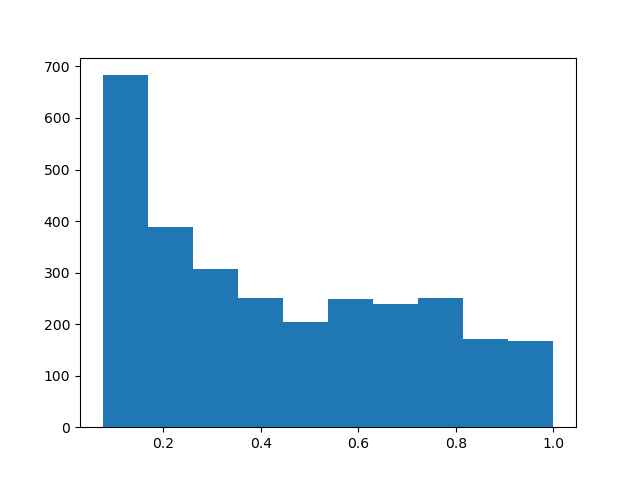

In [ ]:
fig, axs = plt.subplots()
axs.hist(cornerConfsToDescriptorWeights(corner_confs))

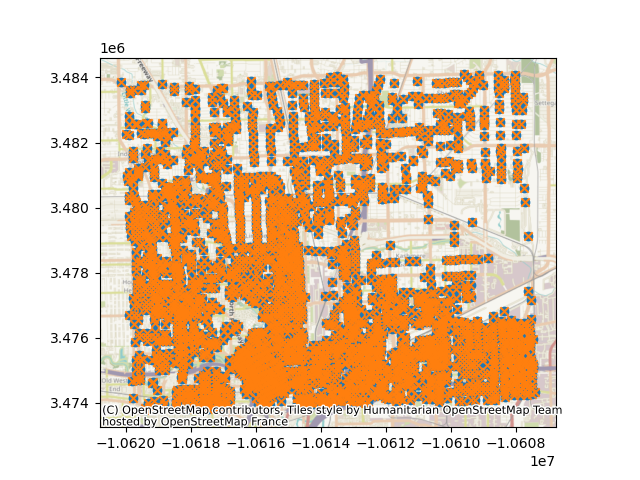

In [ ]:
fig, axs = plt.subplots()

im_corner_gdf_corrected.plot(ax=axs)
im_corner_gdf_adj.plot(ax=axs, marker='x')

cx.add_basemap(axs)


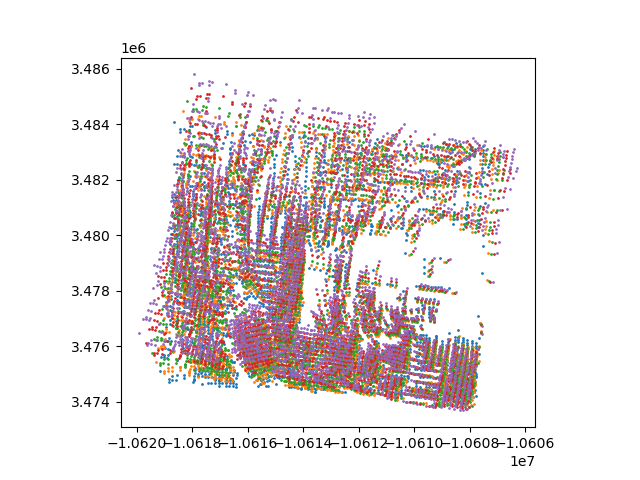

In [ ]:
fig, axs = plt.subplots()

for i in range(5):
    registration_struct['points'][i].plot(ax=axs, markersize=1)

In [ ]:
plt.plot(registration_struct['grades'])